In [8]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import random

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import defaultdict
pio.renderers.default = 'notebook_connected'

import os
sns.set()

if 'notebook' in os.getcwd():
    os.chdir('..')

import gym
import gym.envs.toy_text

# Temporal Differencing (TD)

An approach that combines the benifits of Dynamic Programming (DP) and Monte Carlo (MC) by using bootstrapping from DP and the sample-based approach from MC. Below is the implementation of TD(0) where the 0 refers to one less than how many future states are discounted.

$$ V'(s) = V(s) + \alpha[R + \lambda V(s') - V(s)]$$
$$ Q'(s,a) = Q(s,a) + \alpha[R + \lambda Q(s',a') - Q(s',a')]$$

where:
- $V(s)$: Current value of a state
- $V'(s)$: New value of a state
- $s$: current state
- $s'$: next state after an action is taken
- $\alpha$: learning rate
- $a$: action
- $\lambda$: discount factor

# State-Actio-Reward-State-Action (SARSA)

This is in on-policy control algorithm. It samplw step by step and updates the Q values where the learning rate can be controlled. 

In [34]:
# SARSA Learning agent class

class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        state = tuple(state)
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        state = tuple(state)
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        state = tuple(state)
        next_state = tuple(next_state)
        if not done:
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [35]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [36]:
# plot rewards
def plot_rewards(env_name, rewards, label, n = 20):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-n:])))
    rewards_mean = np.array([np.nan] * len(rewards))
    for i in range(n,len(rewards)):
        rewards_mean[i] = rewards[i-n:i].mean()
    plt.plot(rewards, label=label)
    plt.plot(rewards_mean, label=label + '_mean')
    plt.grid()
    plt.legend()
    plt.show()

In [58]:
# create cliff world environment
#env = gym.envs.toy_text.CliffWalkingEnv()
env = gym.make("CartPole-v1")
print(env.__doc__)

None


In [63]:
# create a SARSA agent
agent = SARSAAgent(
            alpha=0.001,
            epsilon=0.2,
            gamma=0.99,
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 50000)

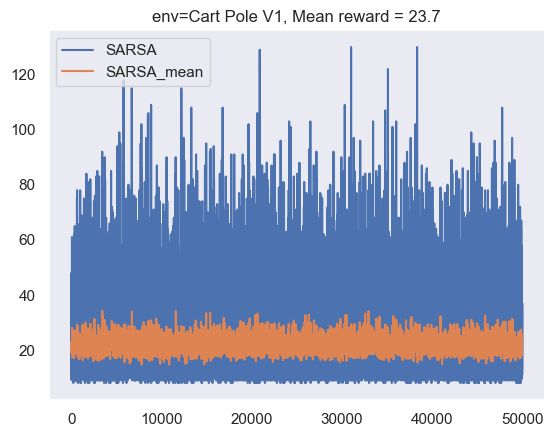

In [64]:
# plot rewards
plot_rewards("Cart Pole V1",rewards, 'SARSA')

In [66]:
tmax = 10000
G = 0
state = env.reset()
action = agent.get_action(state)
for t in range(tmax):
    env.render()
    next_state, reward, done, _ = env.step(action)
    next_action = agent.get_action(next_state)
    G += reward
    if done:
        break
    state = next_state
    action = next_action

ImportError: 
    Cannot import pyglet.
    HINT: you can install pyglet directly via 'pip install pyglet'.
    But if you really just want to install all Gym dependencies and not have to think about it,
    'pip install -e .[all]' or 'pip install gym[all]' will do it.
    

In [ ]:
done = False
current_state = env.reset()
while not done:
        env.render()
        t = t+1
        action = self.choose_action(current_state)
        obs, reward, done, _ = self.env.step(action)
        new_state = self.discretize_state(obs)
        current_state = new_state
    
return t   

# Q-Learning